# Predizione di Valori Partendo da altri sensori
## Contesto e Obiettivo
In molti contesti industriali, alcuni parametri critici non possono essere misurati direttamente per motivi economici, tecnici o logistici. Tuttavia, è spesso disponibile un sensore più economico o approssimativo che fornisce una misura indiretta.

L’obiettivo di questo progetto è costruire un modello predittivo in grado di:
    Stimare il valore effettivo di una variabile target a partire dal dato di un sensore correlato.
    Fornire tale stima anche in situazioni in cui il sensore diretto del valore reale non è disponibile.

L’approccio si basa sull’addestramento di un modello di regressione utilizzando un dataset storico contenente il valore del sensore e solo una parte del valore reale, e un altro valore reale  registrato, ma senza nessun sensore per quel valore.

## Fonte e struttura del dataset

Il dataset utilizzato è [Air-Quality](https://archive.ics.uci.edu/dataset/360/air+quality) scaricato da UC Irvine machine Learning Repository. Il dataset contiene 9358 istanze di misurazioni medie orarie effettuate da una rete di 5 sensori a ossidi metallici integrati in un dispositivo multisensore per il monitoraggio della qualità dell’aria. Il dispositivo era installato a livello stradale in una zona fortemente inquinata di una città italiana. I dati sono stati raccolti tra marzo 2004 e febbraio 2005, rappresentando uno dei più lunghi periodi di acquisizione disponibili pubblicamente per dispositivi di questo tipo installati sul campo.

Ho modificato il file Excel originale eliminando ogni riferimento specifico alle sostanze chimiche, rendendo i dati più generici e adatti a un’analisi focalizzata su variabili sensoriali senza indicazioni esplicite sul tipo di inquinante.

### Variabili principali del dataset

*   **Date**: Data della misurazione nel formato GG/MM/AAAA.
*   **Time**: Ora della misurazione nel formato HH:MM:SS.
*   **Val1**: Valore di riferimento reale per la sostanza 1.
*   **Sensore Val1**: Lettura del sensore corrispondente a Val1.
*   **Val2**: Valore di riferimento reale per la sostanza 2.
*   **Sensore Val2**: Lettura del sensore corrispondente a Val2.
*   **Val3**: Valore di riferimento reale per la sostanza 3.
*   **Sensore Val3**: Lettura del sensore corrispondente a Val3.
*   **Val4**: Valore di riferimento reale per la sostanza 4.
*   **Sensore Val 4**: Lettura del sensore corrispondente a Val4.
*   **Val 5**: Valore di riferimento reale per la sostanza 5 (privo di un sensore specifico).
*   **Sensore O3**: Lettura di un sensore aggiuntivo (es. Ozono).
*   **Temperature**: Temperatura ambientale in gradi Celsius.
*   **Relative Humidity**: Umidità relativa (%).
*   **Absolute Humidity**: Umidità assoluta.

In [14]:
import pandas as pd
import numpy as np

file_path = "AirQualityUCI.csv"
sensors_data_csv = pd.read_csv(file_path)
sensors_data_csv.head()

,Date,Time,Val1,Sensore Val1,Val2,Sensore Val2,Val3,Sensore Val3,Val4,Sensore Val4,Val5,Sensore O3,Temperature,Relative Humidity,Absolute Humidity
0,10/03/2004,18:00:00,2.6,1360,150,11.9,166,1056,113,1692,1046,1268,13.6,48.9,0.7578
1,10/03/2004,19:00:00,2.0,1292,112,9.4,103,1174,92,1559,955,972,13.3,47.7,0.7255
2,10/03/2004,20:00:00,2.2,1402,88,9.0,131,1140,114,1555,939,1074,11.9,54.0,0.7502
3,10/03/2004,21:00:00,2.2,1376,80,9.2,172,1092,122,1584,948,1203,11.0,60.0,0.7867
4,10/03/2004,22:00:00,1.6,1272,51,6.5,131,1205,116,1490,836,1110,11.2,59.6,0.7888


# Preparazione Dataset
In questa fase, il dataset viene pulito e preparato per l'analisi. Le operazioni eseguite sono:

- **Creazione colonna `Datetime`**: Unione di `Date` e `Time` e rimozione delle colonne originali.
- **Creazione feature temporali**: Estrazione di `hour`, `day_of_week`, `month` e `day_of_year`.
- **Conversione a tipo numerico**: Trasformazione di tutte le colonne in `float`.
- **Sostituzione valori mancanti**: Sostituzione del placeholder `-200` con `np.nan`.

In [15]:
sensors_data = sensors_data_csv.copy()

sensors_data.dropna(subset=['Date', 'Time'], inplace=True)

sensors_data['Datetime'] = pd.to_datetime(
    sensors_data['Date'] + ' ' + sensors_data['Time'],
     format='%d/%m/%Y %H:%M:%S', 
    errors='coerce'
)

sensors_data = sensors_data.drop(columns=['Date', 'Time'])

sensors_data['hour'] = sensors_data['Datetime'].dt.hour
sensors_data['day_of_week'] = sensors_data['Datetime'].dt.dayofweek 
sensors_data['month'] = sensors_data['Datetime'].dt.month
sensors_data['day_of_year'] = sensors_data['Datetime'].dt.dayofyear


for col in sensors_data.columns:
    sensors_data[col] = pd.to_numeric(sensors_data[col], errors='coerce').astype(float)

sensors_data = sensors_data.replace(-200, np.nan)    
sensors_data.info()
sensors_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Val1               7674 non-null   float64
 1   Sensore Val1       8991 non-null   float64
 2   Val2               914 non-null    float64
 3   Sensore Val2       8991 non-null   float64
 4   Val3               7718 non-null   float64
 5   Sensore Val3       8991 non-null   float64
 6   Val4               7715 non-null   float64
 7   Sensore Val4       8991 non-null   float64
 8   Val5               8991 non-null   float64
 9   Sensore O3         8991 non-null   float64
 10  Temperature        8991 non-null   float64
 11  Relative Humidity  8991 non-null   float64
 12  Absolute Humidity  8991 non-null   float64
 13  Datetime           9357 non-null   float64
 14  hour               9357 non-null   float64
 15  day_of_week        9357 non-null   float64
 16  month              9357 

,Val1,Sensore Val1,Val2,Sensore Val2,Val3,Sensore Val3,Val4,Sensore Val4,Val5,Sensore O3,Temperature,Relative Humidity,Absolute Humidity,Datetime,hour,day_of_week,month,day_of_year
0,2.6,1360.0,150.0,11.9,166.0,1056.0,113.0,1692.0,1046.0,1268.0,13.6,48.9,0.7578,1.078942e+18,18.0,2.0,3.0,70.0
1,2.0,1292.0,112.0,9.4,103.0,1174.0,92.0,1559.0,955.0,972.0,13.3,47.7,0.7255,1.078945e+18,19.0,2.0,3.0,70.0
2,2.2,1402.0,88.0,9.0,131.0,1140.0,114.0,1555.0,939.0,1074.0,11.9,54.0,0.7502,1.078949e+18,20.0,2.0,3.0,70.0
3,2.2,1376.0,80.0,9.2,172.0,1092.0,122.0,1584.0,948.0,1203.0,11.0,60.0,0.7867,1.078952e+18,21.0,2.0,3.0,70.0
4,1.6,1272.0,51.0,6.5,131.0,1205.0,116.0,1490.0,836.0,1110.0,11.2,59.6,0.7888,1.078956e+18,22.0,2.0,3.0,70.0


## Analisi esplorativa del dataset

In questa sezione vengono analizzate le principali caratteristiche statistiche, la distribuzione delle variabili del dataset, e le correlazioni tra quest'ultime. I risultati guideranno eventuali scelte di filtraggio o trasformazione dei dati.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

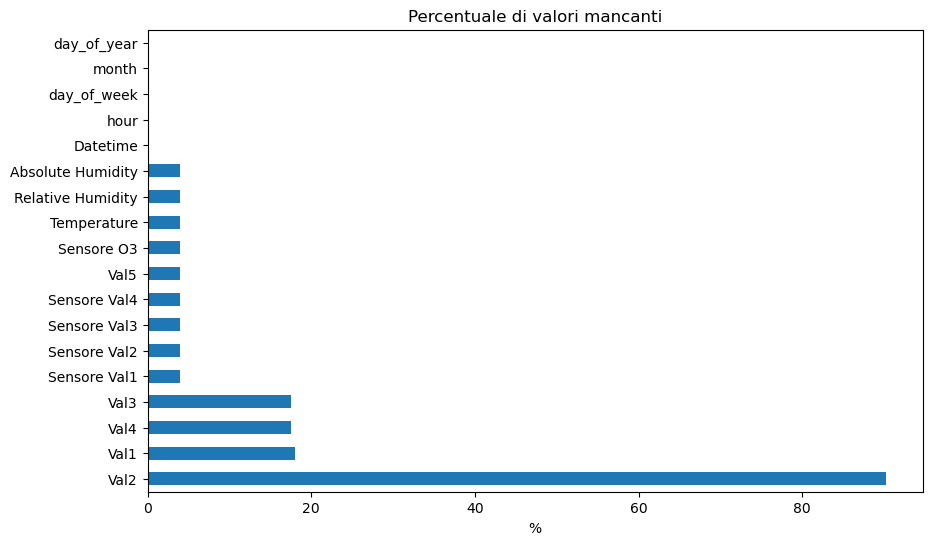

In [17]:
# Percentuale di NaN per colonna
nan_percentage = sensors_data.isna().mean() * 100
nan_percentage.sort_values(ascending=False).plot(kind='barh', figsize=(10,6), title='Percentuale di valori mancanti')
plt.xlabel('%')
plt.show()

### Analisi della relazione tra `Val2` e `Sensore Val2`

Dal grafico precedente emerge che la variabile `Val2` presenta una notevole quantità di valori mancanti.
Si procede ad analizzare la relazione tra `Val2` e il suo sensore dedicato. Per confrontare le due serie temporali su una scala comune, i loro valori vengono normalizzati (scalati tra 0 e 1). Il grafico seguente mostra se, nei punti disponibili, l'andamento di `Sensore Val2` è coerente con quello di `Val2`, giustificandone l'uso come feature predittiva. La Correlazione di Pearson indica che il sensore segue bene l'andamento del valore reale.

In [18]:
def plot_scaled_timeseries(dataframe, col1, col2, time_col='Datetime', title=None):
    """Grafica due colonne scalate tra 0 e 1 nel tempo."""
    dataframe_sorted = dataframe.sort_values(time_col)
    v1 = dataframe_sorted[col1].values.reshape(-1, 1)
    v2 = dataframe_sorted[col2].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(np.hstack([v1, v2]))
    v1_scaled = scaled[:, 0]
    v2_scaled = scaled[:, 1]
    timestamps = dataframe_sorted[time_col]
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, v1_scaled, label=f'{col1} (scalato)')
    plt.plot(timestamps, v2_scaled, label=f'{col2} (scalato)', alpha=0.7)
    plt.xlabel('Tempo')
    plt.ylabel('Valori scalati (0-1)')
    plt.title(title or f'Andamento temporale (scalato): {col1} vs {col2}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_scaled_metrics(df, col1, col2):
    """Calcola correlazione, MSE, RMSE, R2 tra due colonne scalate (solo dove entrambe non sono NaN)."""
    mask = df[col1].notna() & df[col2].notna()
    df_common = df.loc[mask].copy().sort_values('Datetime')
    v1 = df_common[col1].values.reshape(-1, 1)
    v2 = df_common[col2].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(np.hstack([v1, v2]))
    v1_scaled = scaled[:, 0]
    v2_scaled = scaled[:, 1]
    df_scaled = pd.DataFrame({col1: v1_scaled, col2: v2_scaled})
    corr = df_scaled[col2].corr(df_scaled[col1])
    mse = mean_squared_error(df_scaled[col1], df_scaled[col2])
    rmse = mse**0.5
    r2 = r2_score(df_scaled[col1], df_scaled[col2])
    print(f"Correlazione di Pearson (scalate): {corr:.3f}")
    print(f"MSE (scalate): {mse:.3f}")
    print(f"RMSE (scalate): {rmse:.3f}")
    print(f"R² (scalate): {r2:.3f}")



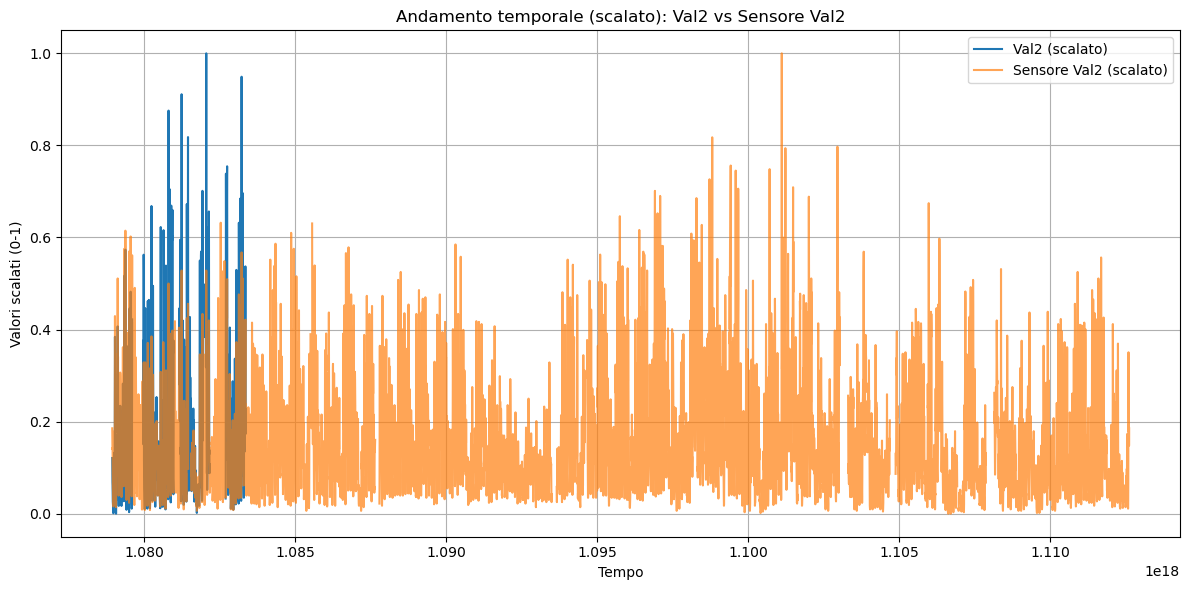

Correlazione di Pearson (scalate): 0.903
MSE (scalate): 0.012
RMSE (scalate): 0.110
R² (scalate): 0.603


In [19]:
plot_scaled_timeseries(sensors_data, 'Val2', 'Sensore Val2')
get_scaled_metrics(sensors_data, 'Val2', 'Sensore Val2')

### Analisi della relazione tra sensori e valori reali

È fondamentale verificare l'affidabilità degli altri sensori. Analizzeremo quindi la relazione tra le coppie di valori reali e i rispettivi sensori (es. `Val1` vs `Sensore Val1`) per capire quanto le letture dei sensori siano rappresentative dei valori effettivi.

- **Sensore 1 (`Val1` vs `Sensore Val1`)**  
  Questo sensore mostra una **correlazione di Pearson alta e positiva** con il valore reale. Significa che segue bene l’andamento della variabile di riferimento ed è affidabile come sensore del valore reale.

- **Sensore 3 (`Val3` vs `Sensore Val3`)**  
  Qui la **correlazione è negativa**: il sensore si muove in direzione opposta rispetto al valore reale. Questo comportamento è anomalo e indica che il sensore non è adatto a rappresentare la variabile di riferimento.

- **Sensore 2 (`Val4` vs `Sensore Val4`)**  
  In questo caso la **correlazione è molto bassa**: il sensore non fornisce informazioni utili sul valore reale. Non è quindi affidabile per stimare la variabile di riferimento.


--- Analisi Val1 vs Sensore Val1 (scalate) ---


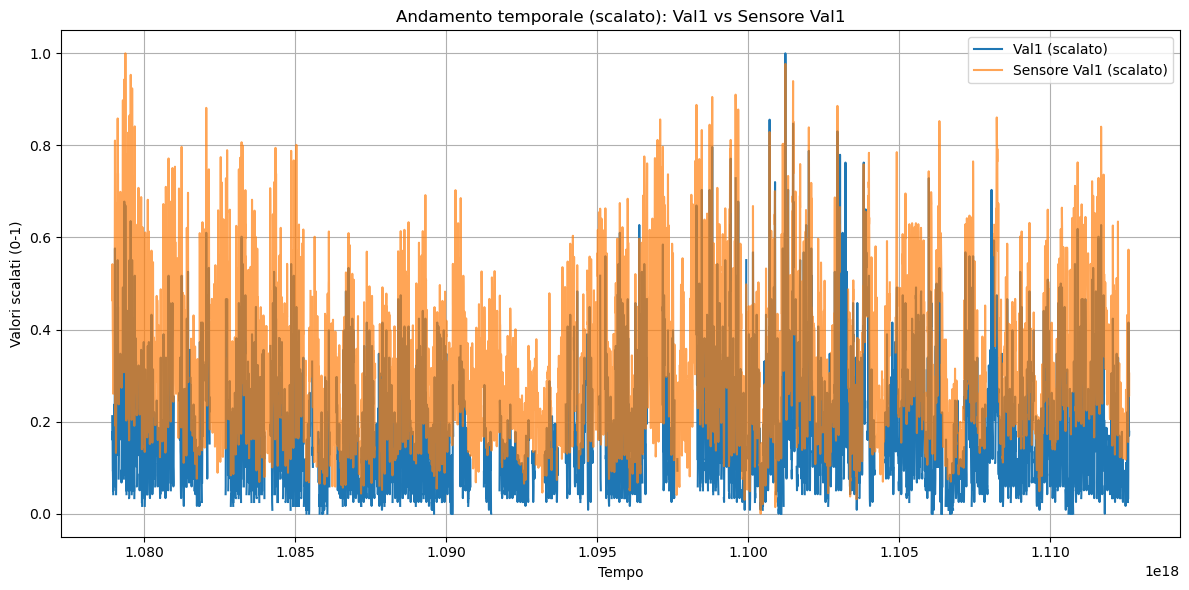

Correlazione di Pearson (scalate): 0.879
MSE (scalate): 0.032
RMSE (scalate): 0.178
R² (scalate): -1.140

--- Analisi Val3 vs Sensore Val3 (scalate) ---


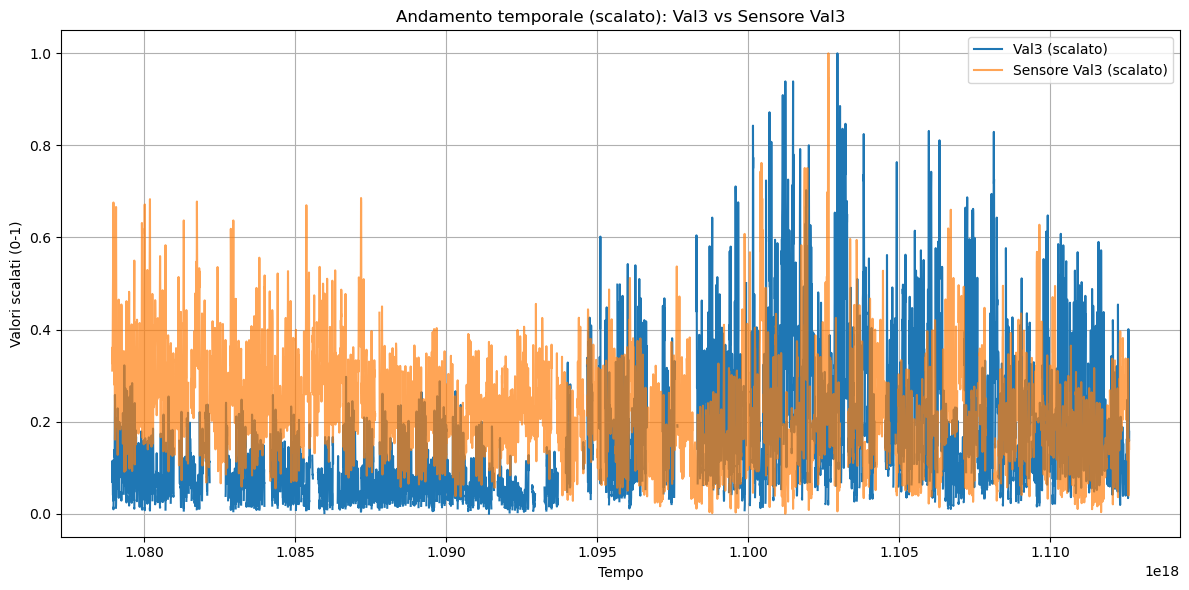

Correlazione di Pearson (scalate): -0.656
MSE (scalate): 0.054
RMSE (scalate): 0.232
R² (scalate): -1.758

--- Analisi Val4 vs Sensore Val4 (scalate) ---


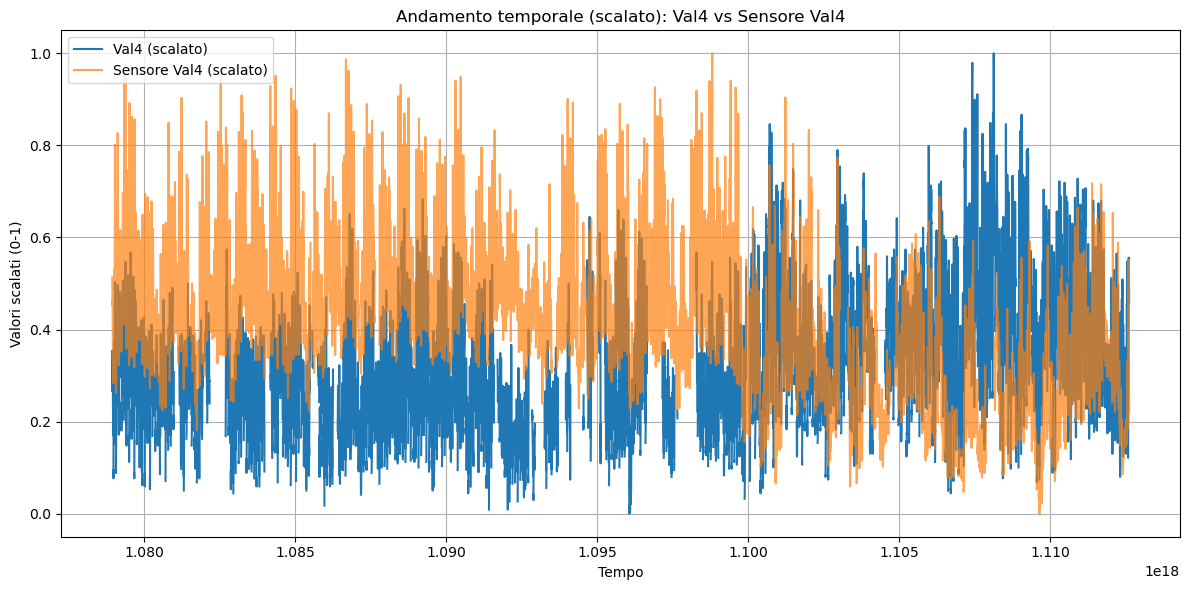

Correlazione di Pearson (scalate): 0.157
MSE (scalate): 0.044
RMSE (scalate): 0.210
R² (scalate): -1.126


In [20]:
analisi_pairs = [
    ('Val1', 'Sensore Val1'),
    ('Val3', 'Sensore Val3'),
    ('Val4', 'Sensore Val4')
]

for val, sensore in analisi_pairs:
    print(f"\n--- Analisi {val} vs {sensore} (scalate) ---")
    plot_scaled_timeseries(sensors_data, val, sensore)
    get_scaled_metrics(sensors_data, val, sensore)

### Analisi Esplorativa di `Val 5`

La variabile `Val 5` è di particolare interesse poiché, a differenza delle altre, non dispone di un sensore dedicato. L'obiettivo finale sarà quindi quello di predirla utilizzando le altre misurazioni disponibili (valori reali, dati ambientali e temporali).

Prima di procedere con la modellazione, è utile condurre un'analisi esplorativa per comprenderne le caratteristiche:

- **Distribuzione**: L'istogramma mostra che i valori di `Val 5` sono distribuiti in modo abbastanza normale, senza particolari asimmetrie o picchi anomali.
- **Outlier**: Dal boxplot si osserva la presenza di pochi outlier, che non sembrano particolarmente influenti rispetto al resto dei dati.
- **Andamento Temporale**: Lo scatter plot rispetto al giorno dell'anno non evidenzia pattern stagionali o trend particolari; la variabile appare piuttosto stabile nel tempo.

Nel complesso, `Val 5` si presenta come una variabile ben distribuita e priva di anomalie significative, il che facilita le successive fasi di modellazione.


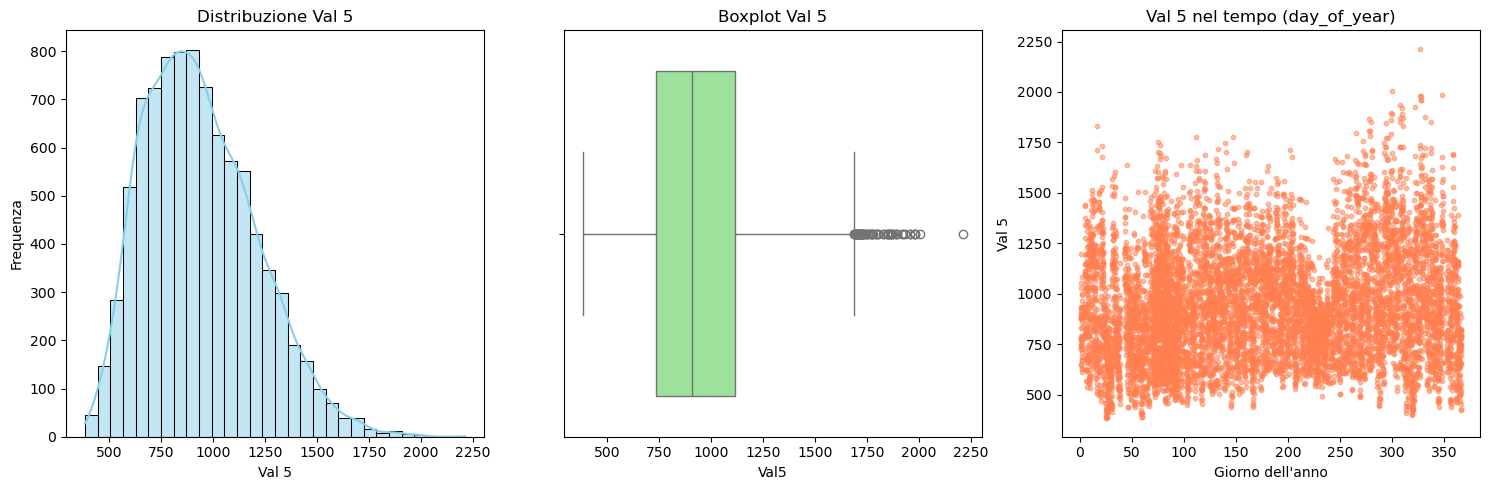

In [36]:
val5 = sensors_data['Val5'].dropna()

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(val5, bins=30, kde=True, color='skyblue')
plt.title('Distribuzione Val 5')
plt.xlabel('Val 5')
plt.ylabel('Frequenza')

plt.subplot(1,3,2)
sns.boxplot(x=val5, color='lightgreen')
plt.title('Boxplot Val 5')

plt.subplot(1,3,3)
plt.scatter(sensors_data['day_of_year'], sensors_data['Val5'], alpha=0.5, s=10, color='coral')
plt.title('Val 5 nel tempo (day_of_year)')
plt.xlabel('Giorno dell\'anno')
plt.ylabel('Val 5')

plt.tight_layout()
plt.show()


### Matrice di correlazione tra variabili numeriche
 
La matrice di correlazione evidenzia forti legami positivi tra le letture dei sensori e i corrispondenti valori reali (es. `Sensore Val1` e `Val1`). Si nota anche una correlazione significativa tra i diversi gruppi di sensori. Al contrario, le variabili ambientali come `Temperature`, `Relative Humidity` e le feature temporali (`hour`, `month`) mostrano una correlazione più debole con i valori dei sensori. 

L'alta correlazione tra sensori e valori reali conferma che i sensori sono feature predittive molto forti. La correlazione incrociata tra i sensori suggerisce che potrebbero essere utilizzati per stimarsi a vicenda, il che è fondamentale per l'obiettivo di predire `Val5` senza l'utilizzo di un sensore. Le variabili ambientali e temporali, sebbene meno correlate, potrebbero comunque catturare dinamiche secondarie utili al modello.
Si nota, come visto prima, che il sensore Val3 funziona effettivamente al contrario.

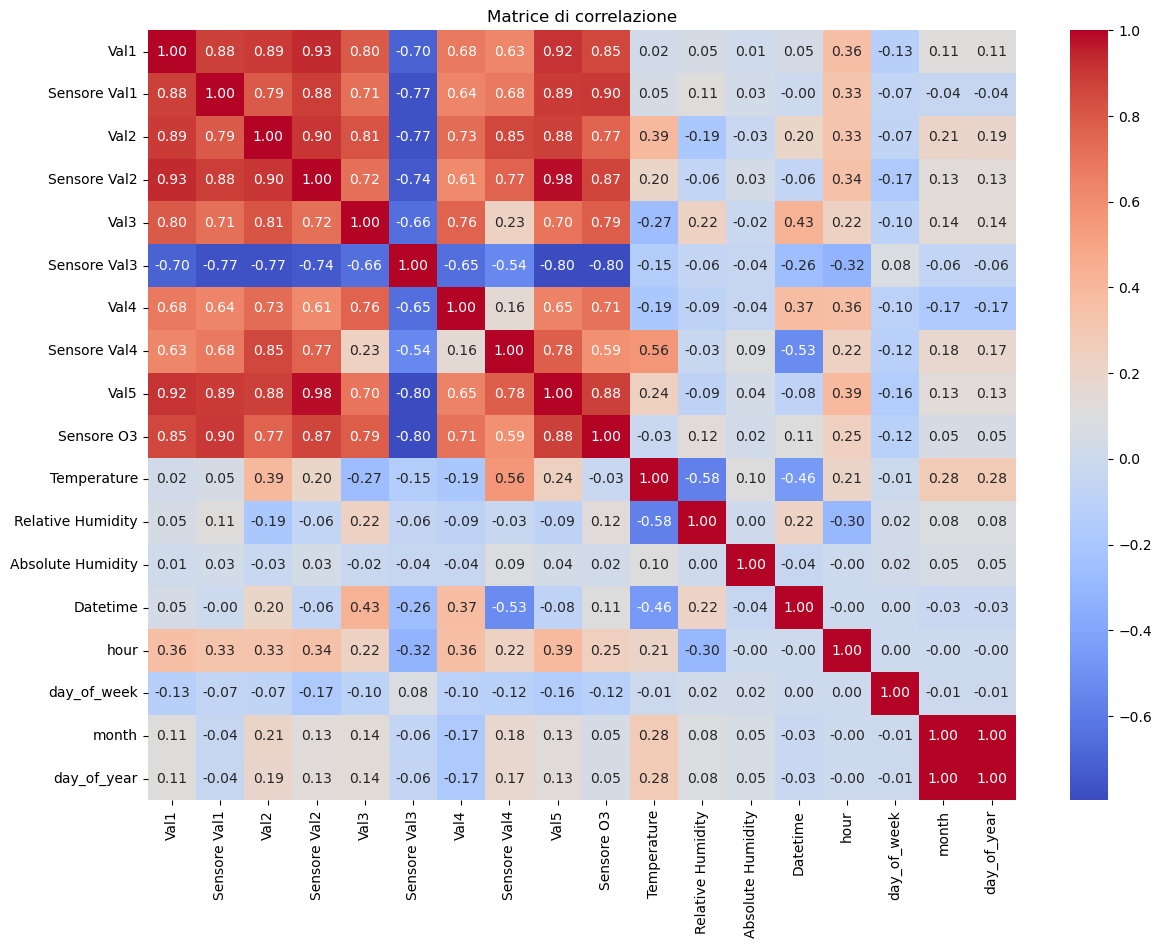

In [22]:
corr = sensors_data.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Matrice di correlazione")
plt.show()


# Ricostruzione dei valori mancanti di Val2 tramite il suo sensore

In questa sezione ci concentriamo esclusivamente sulla variabile `Val2` e sul suo sensore dedicato (`Sensore Val2`).  
L’obiettivo è **completare i valori mancanti di `Val2`** sfruttando la relazione con il sensore, così da poter utilizzare una serie storica più completa nelle fasi successive di modellazione.

- Completamento dei valori mancanti di `Val2` tramite:
  - **Regressione lineare semplice**: si utilizza solo la relazione diretta tra sensore e valore reale.
  - **Modelli più complessi**: si sfruttano anche altre variabili disponibili (ad esempio, altri sensori e dati ambientali) per migliorare la stima dei valori mancanti.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [24]:
# Preparazione dati per regressione lineare a due variabili
feature_col = 'Sensore Val2'
target_col = 'Val2'

data = sensors_data[[feature_col, target_col]].dropna()
X = data[[feature_col]]
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

--- Risultati Regressione Lineare Semplice ---
Coefficiente (pendenza): 25.4701
Intercetta: -41.1785
Mean Squared Error (MSE): 8776.1390
Root Mean Squared Error (RMSE): 93.6810
R-squared (R²): 0.7949


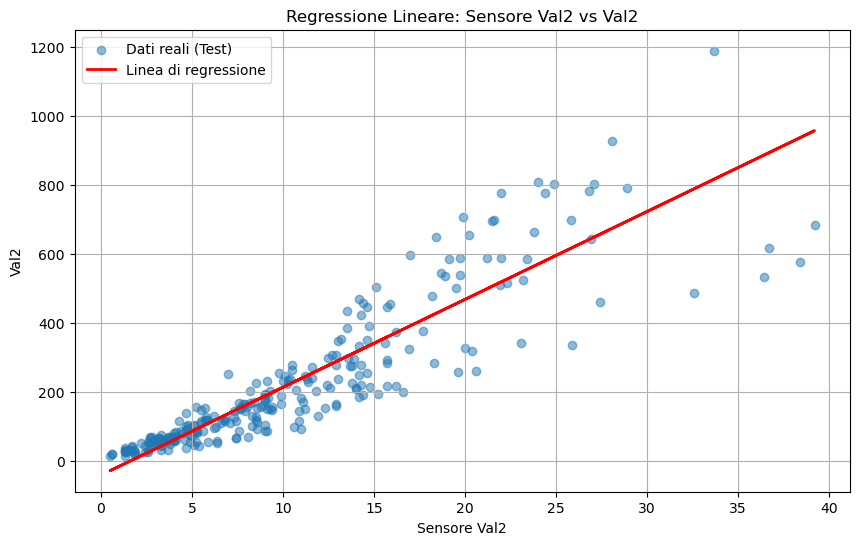

In [25]:

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("--- Risultati Regressione Lineare Semplice ---")
print(f"Coefficiente (pendenza): {linear_model.coef_[0]:.4f}")
print(f"Intercetta: {linear_model.intercept_:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse):.4f}")
print(f"R-squared (R²): {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, alpha=0.5, label='Dati reali (Test)')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Linea di regressione')
plt.title(f'Regressione Lineare: {feature_col} vs {target_col}')
plt.xlabel(feature_col)
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()

I risultati della regressione lineare semplice sono già molto buoni, con un R² di circa 0.79, dimostrando che `Sensore Val2` è un predittore forte per `Val2`. Visto l'ottimo punto di partenza, l'applicazione di una regressione polinomiale su questa singola feature sarebbe superflua. Risulta più strategico passare direttamente a modelli più complessi (Ridge, Lasso, ElasticNet) che utilizzano non solo `Sensore Val2`, ma anche tutte le altre variabili disponibili per migliorare ulteriormente la precisione.

Questo approccio ci permetterà anche di analizzare l'importanza dei diversi parametri. Successivamente, confronteremo le performance dei modelli tramite validazione incrociata (K-Fold) per identificare il più robusto e, per il modello migliore, effettueremo una ricerca degli iperparametri ottimali per massimizzarne l'accuratezza.

In [ ]:
def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test, plot = False):
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')), # sostituisce i Nan, con la mediana della colonna
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    
    coefs = None
    intercept = None
    if hasattr(pipeline.named_steps['regressor'], 'coef_'):
        coefs = pipeline.named_steps['regressor'].coef_
        intercept = pipeline.named_steps['regressor'].intercept_

    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    if plot:
        plt.figure(figsize=(8, 5))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Valori Reali")
        plt.ylabel(f"Predizioni {model_name}")
        plt.title(f"{model_name}: Predizioni vs Valori Reali")
        plt.grid(True)
        plt.show()

    return {
        'model_name': model_name,
        'coefficients': coefs,
        'intercept': intercept,
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    }

def cross_validate_model(model, model_name, X, y, scoring='neg_root_mean_squared_error', k=5):
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    cv = KFold(n_splits=k, shuffle=True, random_state=42)
    
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    mean_score = -np.mean(scores)  # sklearn restituisce score negativo per RMSE
    std_score = np.std(scores)

    return {
        'model_name': model_name,
        'cv_rmse_mean': mean_score,
        'cv_rmse_std': std_score,
        'pipeline': pipeline
    }

In [27]:
# preparazione dati, utilizzo i valori reali, non i sensori.
feature_cols = [
    'Val1', 'Sensore Val2', 'Val3', 'Val4', 'Val5',
    'Sensore O3',
    'Temperature',
    'Relative Humidity',
    'Absolute Humidity',
    'hour', 'day_of_week', 'month', 'day_of_year'
]
df_model = sensors_data[feature_cols + [target_col]].dropna()
X = df_model[feature_cols]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
results = []
results.append(train_and_evaluate(Ridge(alpha=1.0, random_state=42), "Ridge", X_train, X_test, y_train, y_test, False))
results.append(train_and_evaluate(Lasso(alpha=0.1, random_state=42, max_iter=10000), "Lasso", X_train, X_test, y_train, y_test, False))
results.append(train_and_evaluate(ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000), "ElasticNet", X_train, X_test, y_train, y_test, False))


coef_df = pd.DataFrame({
    r['model_name']: r['coefficients'] for r in results if r['coefficients'] is not None
}, index=feature_cols)
print("\nCoefficiente per ogni modello:")
print(coef_df)


metrics_df = pd.DataFrame(results).set_index('model_name')[['mse', 'rmse', 'r2']]
print("\nMetriche di test set:")
print(metrics_df)

# Cross-validation
cv_results = []
cv_results.append(cross_validate_model(Ridge(alpha=1.0, random_state=42), "Ridge", X, y,  scoring='neg_root_mean_squared_error'))
cv_results.append(cross_validate_model(Lasso(alpha=0.1, random_state=42, max_iter=10000), "Lasso", X, y, scoring='neg_root_mean_squared_error'))
cv_results.append(cross_validate_model(ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000), "ElasticNet", X, y,  scoring='neg_root_mean_squared_error'))

cv_df = pd.DataFrame(cv_results).set_index("model_name")
print("\nRisultati Cross-Validation (RMSE):")
print(cv_df.drop(columns=['pipeline']))


Coefficiente per ogni modello:
                        Ridge       Lasso  ElasticNet
Val1               150.651171  153.932678   92.667261
Sensore Val2        96.722225   99.466723   72.992552
Val3               -65.737440  -67.012973  -10.879263
Val4                16.405865   16.148471    8.530718
Val5                14.850731    8.924842   37.308656
Sensore O3         -14.713664  -13.541771   -9.452616
Temperature        -37.146965  -36.396917  -24.718030
Relative Humidity  -28.108378  -27.835127  -20.214439
Absolute Humidity   -9.333943   -9.252766   -9.097626
hour                -9.716521   -9.478755   -3.631257
day_of_week        -10.263899  -10.221627   -8.970589
month               30.691257   30.567447   27.783030
day_of_year         20.180471   20.054362   20.827915

Metriche di test set:
                    mse       rmse        r2
model_name                                  
Ridge       5825.429751  76.324503  0.863529
Lasso       5836.690928  76.398239  0.863265
ElasticNe

### Selezione del Modello e Analisi dei Coefficienti

1.  **Performance Generale**: Tutti e tre i modelli mostrano ottime performance, con un valore di R² superiore a 0.85. Questo indica che oltre l'85% della variabilità di `Val2` viene spiegata dai modelli.
2.  **Miglior Modello**: Il modello **Ridge** emerge come il migliore, sebbene con un margine molto ridotto. Ha l'RMSE più basso e l'R² più alto sia sul singolo test set che nella media della validazione incrociata.
3.  **Robustezza**: La validazione incrociata conferma la stabilità dei risultati. L'RMSE medio di Ridge è il più basso, indicando che le sue performance sono consistenti su diverse partizioni dei dati. La deviazione standard (±) simile tra i modelli suggerisce che hanno tutti una variabilità di performance comparabile.


#### Analisi dei Coefficienti

I coefficienti del modello ci aiutano a capire il peso e la direzione dell'influenza di ciascuna feature sulla predizione.

*   **Feature più Influenti**: `Val1` e `Sensore Val2` hanno i coefficienti positivi più alti in tutti i modelli. Questo conferma l'intuizione che il valore reale di un'altra sostanza e il sensore dedicato a `Val2` siano i predittori più forti.
*   **Relazioni Negative**: `Val3` e `Temperature` mostrano coefficienti negativi consistenti e di magnitudine rilevante. Ciò significa che all'aumentare dei loro valori, il modello tende a predire un valore più basso per `Val2`.
*   **Lasso vs Ridge**: È interessante notare che i coefficienti di Lasso e Ridge sono molto simili. Poiché Lasso è noto per azzerare i coefficienti delle feature meno importanti e qui non l'ha fatto, possiamo dedurre che tutte le feature selezionate forniscono un contributo, seppur minimo, alla predizione.
*   **ElasticNet**: ElasticNet è un modello ibrido che combina le penalità di Lasso (L1) e Ridge (L2). I suoi coefficienti sono spesso un compromesso tra i due. In questo caso, notiamo che i coefficienti di ElasticNet sono generalmente più piccoli in valore assoluto rispetto a quelli di Lasso e Ridge.

In sintesi, l'analisi conferma la scelta di **Ridge** come modello ottimale e rivela che la predizione di `Val2` si basa principalmente su `Val1` e `Sensore Val2`, con correzioni apportate dalle altre variabili ambientali e temporali.

In [42]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

pipeline_ridge = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', Ridge(random_state=42))
])


param_grid = {
    'regressor__alpha': np.logspace(-3, 3, 50)  
}

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)


grid_search = GridSearchCV(
    estimator=pipeline_ridge,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=inner_cv,
    n_jobs=-1  # Usa tutti i core della CPU
)


print("Avvio della Nested Cross-Validation per Ridge...")
nested_scores = cross_val_score(
    estimator=grid_search,
    X=X, 
    y=y,
    cv=outer_cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)


nested_scores = -nested_scores
print("\n--- Risultati della Nested Cross-Validation ---")
print(f"RMSE medio (stima imparziale): {nested_scores.mean():.4f}")
print(f"Deviazione standard RMSE: {nested_scores.std():.4f}")

# Addestraro il modello finale sull'intero dataset per trovare i migliori iperparametri e avere un modello pronto all'uso.
print("\nAddestramento del modello finale sull'intero dataset...")
grid_search.fit(X, y)
print(f"Miglior valore di alpha trovato: {grid_search.best_params_['regressor__alpha']:.4f}")
print(f"Miglior RMSE (CV sul ciclo interno) con i dati completi: {-grid_search.best_score_:.4f}")


final_model = grid_search.best_estimator_

Avvio della Nested Cross-Validation per Ridge...

--- Risultati della Nested Cross-Validation ---
RMSE medio (stima imparziale): 77.8374
Deviazione standard RMSE: 6.4499

Addestramento del modello finale sull'intero dataset...
Miglior valore di alpha trovato: 2.6827
Miglior RMSE (CV sul ciclo interno) con i dati completi: 77.9462


### Passaggio a un Modello Non Lineare: Random Forest

L'ottimizzazione degli iperparametri ha confermato che il modello Ridge era già molto vicino alla sua performance ottimale, dato che il valore `alpha` trovato (2.68) era prossimo a quello di default (1.0) e ha portato a un miglioramento trascurabile. Questo suggerisce che abbiamo raggiunto il limite di ciò che un modello lineare può estrarre da questi dati.

Per superare questa limitazione, passeremo ora a un modello intrinsecamente diverso: il **Random Forest Regressor**. A differenza dei modelli lineari, il Random Forest è un modello basato su alberi decisionali (ensemble) in grado di catturare relazioni complesse e non lineari tra le feature, offrendo potenzialmente un miglioramento significativo della precisione.

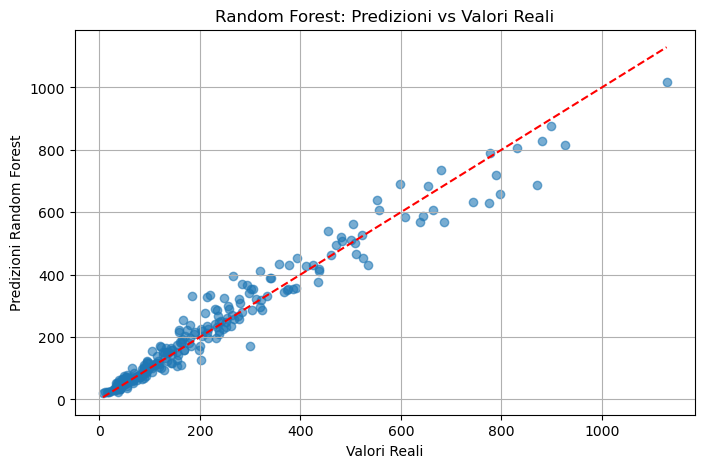


Metriche di test set:
                       mse       rmse        r2
model_name                                     
Random Forest  1763.996945  41.999964  0.958675
Random Forest - RMSE medio: 44.0984 (± 2.8703)

--- Feature Importances (Random Forest per Val2) ---
              Feature  Importance
0                Val1    0.363470
4                Val5    0.316138
1        Sensore Val2    0.195795
12        day_of_year    0.088182
7   Relative Humidity    0.005943
3                Val4    0.005755
8   Absolute Humidity    0.005582
2                Val3    0.004961
5          Sensore O3    0.004172
6         Temperature    0.003757
9                hour    0.003107
10        day_of_week    0.002297
11              month    0.000842


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
results = train_and_evaluate(rf_model, "Random Forest", X_train, X_test, y_train, y_test, True)


metrics_df = pd.DataFrame([results]).set_index('model_name')[['mse', 'rmse', 'r2']]
print("\nMetriche di test set:")
print(metrics_df)


cv_results_rf = cross_validate_model(rf_model, "Random Forest", X, y, scoring='neg_root_mean_squared_error', k=5)


rf_pipeline = cv_results_rf['pipeline']


importances = rf_pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importances (Random Forest per Val2) ---")
print(feature_importance_df)


### Analisi del Modello Random Forest e Imputazione di `Val2`

Il passaggio al modello **Random Forest** ha portato a un **miglioramento sostanziale** delle performance. L'R² è salito a circa **0.96**, superando nettamente i modelli lineari (che si attestavano intorno a 0.86). Questo dimostra la capacità del Random Forest di catturare le relazioni non lineari complesse presenti nei dati, che i modelli precedenti non riuscivano a cogliere.

L'analisi delle **feature importance** rivela un quadro molto interessante e diverso rispetto ai coefficienti dei modelli lineari:

1.  **Nuovi Predittori Dominanti**: `Val1` e `Val5` emergono come le feature più importanti, superando persino `Sensore Val2`. Il modello ha imparato che i valori reali di altre sostanze sono predittori estremamente forti per `Val2`, probabilmente perché catturano dinamiche ambientali e chimiche condivise.
2.  **Ruolo di `Sensore Val2`**: Sebbene non sia più la feature dominante, `Sensore Val2` rimane comunque il terzo predittore più importante, confermando la sua utilità.
3.  **Importanza delle Feature Temporali**: Anche `day_of_year` assume un'importanza non trascurabile, indicando che il modello è riuscito a identificare pattern stagionali utili alla predizione.

Dato l'evidente vantaggio in termini di accuratezza, utilizzeremo questo modello Random Forest per il nostro obiettivo finale: **ricostruire i valori mancanti di `Val2`**. Addestreremo la pipeline su tutti i dati disponibili e la useremo per imputare i valori mancanti, creando così un dataset più completo per le successive fasi di analisi, come la taratura di `Val3` e la predizione di `Val5`.

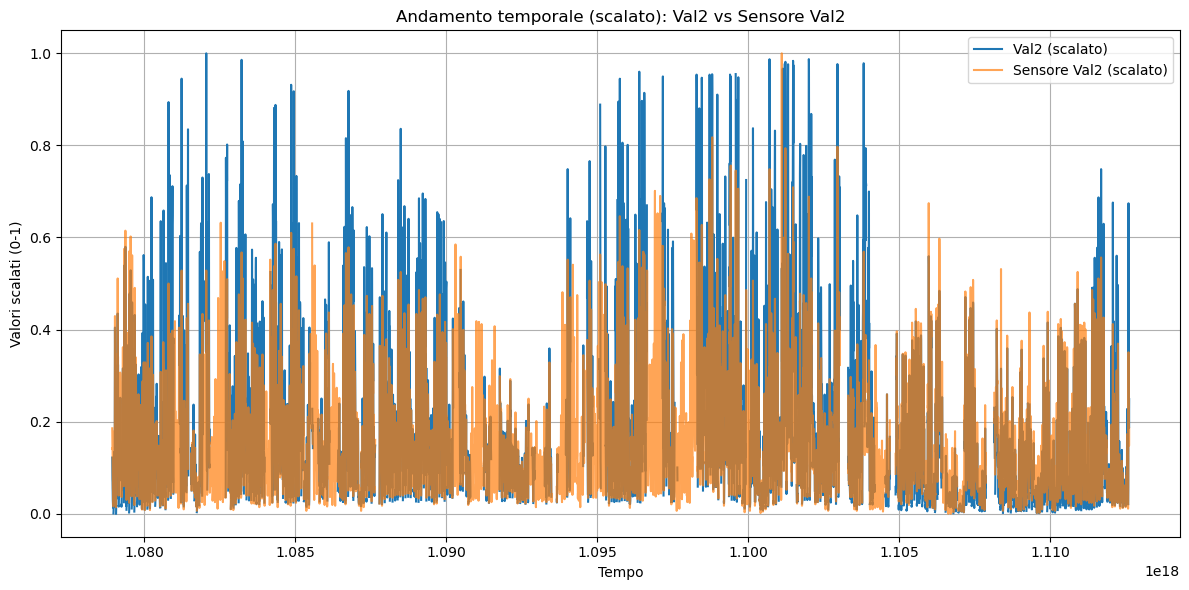

Correlazione di Pearson (scalate): 0.939
MSE (scalate): 0.006
RMSE (scalate): 0.080
R² (scalate): 0.795


In [ ]:
df_model = sensors_data[feature_cols + ['Val2']].dropna()
rf_pipeline.fit(df_model[feature_cols], df_model['Val2'])


mask_features = sensors_data[feature_cols].notna().all(axis=1)


val2_pred = pd.Series(index=sensors_data.index, dtype=float)
val2_pred[mask_features] = rf_pipeline.predict(sensors_data.loc[mask_features, feature_cols])


sensors_data_new = sensors_data.copy()
sensors_data_new['Val2'] = val2_pred


plot_scaled_timeseries(sensors_data_new, 'Val2', 'Sensore Val2')
get_scaled_metrics(sensors_data_new, 'Val2', 'Sensore Val2')

# Taratura sensore Val3

In questa sezione ci concentriamo sulla variabile `Val3` e sul suo sensore dedicato (`Sensore Val3`).  
A differenza di altri casi, **il problema principale non è la presenza di valori mancanti**, ma il fatto che il sensore fornisce una misura poco affidabile o addirittura fuorviante rispetto al valore reale.

L’obiettivo è quindi **"tarare" il sensore**, ovvero costruire un modello che, sfruttando tutte le altre variabili disponibili (altri sensori, dati ambientali e temporali), permetta di stimare il valore reale di `Val3` anche quando la lettura del sensore è distorta o non rappresentativa.

L’analisi delle feature importance mostra che, nonostante tutto, la variabile che contribuisce maggiormente alla stima di `Val3` resta proprio la lettura del suo sensore (`Sensore Val3`), seguita dalle altre feature che aiutano il modello a correggere le distorsioni del sensore.

In [ ]:
feature_cols_val3 = [
    'Sensore Val3', 'Val1',  'Val2',  'Val4', 
    'Val5', 'Sensore O3', 'Temperature', 'Relative Humidity', 'Absolute Humidity',
    'hour', 'day_of_week', 'month', 'day_of_year'
]
target_col = 'Val3'

df_model = sensors_data_new[feature_cols_val3 + [target_col]].dropna()
X = df_model[feature_cols_val3]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Random Forest - Test set: MSE=2018.8974, R2=0.9495


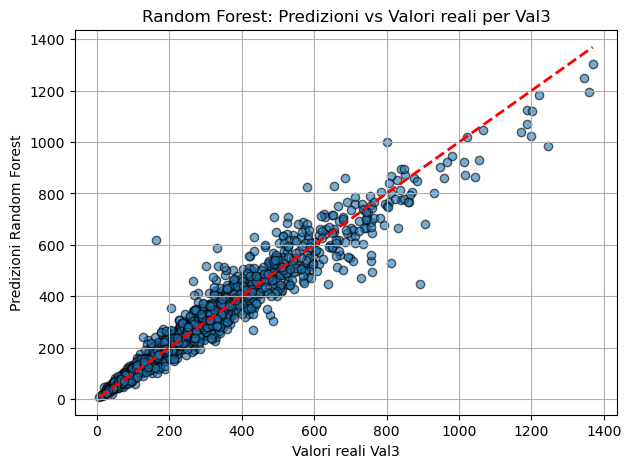

Random Forest - R2 medio (CV): 0.9562 (± 0.0060)

--- Feature Importances (Random Forest per Val3) ---
              Feature  Importance
0        Sensore Val3    0.549711
3                Val4    0.165340
12        day_of_year    0.077728
5          Sensore O3    0.060644
6         Temperature    0.040568
2                Val2    0.028460
1                Val1    0.025821
4                Val5    0.021926
7   Relative Humidity    0.009600
9                hour    0.006929
8   Absolute Humidity    0.006189
11              month    0.004907
10        day_of_week    0.002178


In [ ]:
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Addestramento e valutazione su test set
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nRandom Forest - Test set: MSE={mse:.4f}, R2={r2:.4f}")

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valori reali Val3")
plt.ylabel("Predizioni Random Forest")
plt.title("Random Forest: Predizioni vs Valori reali per Val3")
plt.grid(True)
plt.show()

# Validazione incrociata (K-Fold)
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
scores = cross_val_score(rf_pipeline, X, y, cv=kf, scoring='r2')
print(f"Random Forest - R2 medio (CV): {scores.mean():.4f} (± {scores.std():.4f})")

importances = rf_pipeline.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols_val3,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importances (Random Forest per Val3) ---")
print(feature_importance_df)

# Predizione di Val 5 (senza sensore dedicato)

La variabile `Val 5` rappresenta un valore reale di interesse che, a differenza delle altre, **non dispone di un sensore dedicato**. L’obiettivo di questa sezione è costruire un modello predittivo in grado di stimare `Val 5` utilizzando tutte le altre misurazioni disponibili: valori reali delle altre sostanze, letture dei sensori, variabili ambientali e temporali.

Questo approccio è particolarmente utile in contesti reali dove non è economicamente o tecnicamente possibile installare un sensore specifico per ogni parametro di interesse. Il modello sfrutta la correlazione tra le variabili per fornire una stima affidabile di `Val 5` anche in assenza di una misura diretta.


In [ ]:
feature_cols_val5 = [
    'Val1', 'Val2',  'Val3', 
    'Val4',  'Sensore O3', 'Temperature',
    'Relative Humidity', 'Absolute Humidity',
    'hour', 'day_of_week', 'month', 'day_of_year'
]
target_col = 'Val5'


df_model = sensors_data_new[feature_cols_val5 + [target_col]].dropna()
X = df_model[feature_cols_val5]
y = df_model[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Random Forest - Test set: MSE=1174.7834, R2=0.9833


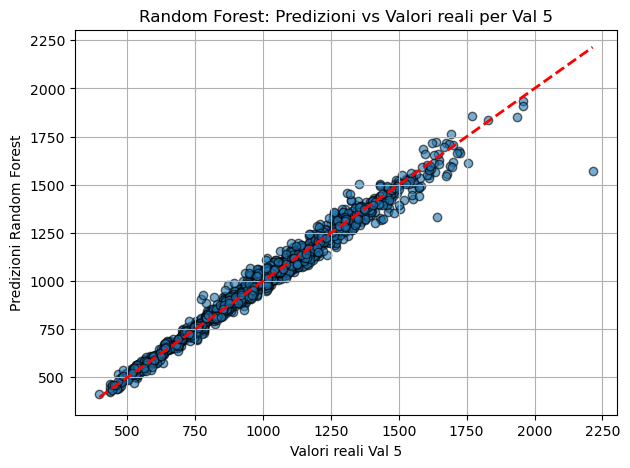

Random Forest - R2 medio (CV): 0.9863 (± 0.0017)

--- Feature Importances (Random Forest per Val 5) ---
              Feature  Importance
1                Val2    0.915072
11        day_of_year    0.024729
0                Val1    0.021504
4          Sensore O3    0.018280
2                Val3    0.006423
5         Temperature    0.003714
7   Absolute Humidity    0.003379
3                Val4    0.002303
8                hour    0.001643
6   Relative Humidity    0.001602
9         day_of_week    0.000850
10              month    0.000501


In [ ]:
rf_pipeline_val5 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline_val5.fit(X_train, y_train)
y_pred = rf_pipeline_val5.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nRandom Forest - Test set: MSE={mse:.4f}, R2={r2:.4f}")

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valori reali Val 5")
plt.ylabel("Predizioni Random Forest")
plt.title("Random Forest: Predizioni vs Valori reali per Val 5")
plt.grid(True)
plt.show()


k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
scores = cross_val_score(rf_pipeline_val5, X, y, cv=kf, scoring='r2')
print(f"Random Forest - R2 medio (CV): {scores.mean():.4f} (± {scores.std():.4f})")


importances = rf_pipeline_val5.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols_val5,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importances (Random Forest per Val 5) ---")
print(feature_importance_df)